<script>
    var code_show=true; //true -> hide code at first

    function code_toggle() {
        $('div.prompt').hide(); // always hide prompt

        if (code_show){
            $('div.input').hide();
        } else {
            $('div.input').show();
        }
        code_show = !code_show
    }
    $( document ).ready(code_toggle);
</script>

# PART | (DECOUPLED ACTIONS)

Quadcopter represent a very interesting control problem, with their very simple design and high agility they are extremely versatile, multirotors are used across a wide spectrum of fields, starting from aerial photography to emergency response and disaster relief. A quadcopter consist of four independent rotors and 6 degrees of freedom(three translational and three rotational), quadcopters are considered under-actuated, because to have 6 degrees of translational and rotational of freedom, translational and rotational motion are coupled, resulting in a highly nonlinear flight dynamics[1]. The aim of this work is to utilize model-based reinforcement learning methods, to do effective and adaptive motion planning and obstacle avoidance.


### Table of content:

#### 1. Unit testing
#### 2. Data preperation
#### 3. Data exploration
#### 4. Model identification
#### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; &nbsp;3.1 Velocity-based models
        4.1.1 MLP
        4.1.2 Gradient Boost
#### 5. Models evaluation
        5.1 MLP
        5.2 Gradient Boost
#### 6. Model verification
    6.1 Integrating predictions (Multi-step ahead)
    6.2 Building 2d Simulator based on learned Model

In [1]:
import sys
sys.path.append('..')

In [2]:
from bokeh.plotting import figure, show, output_notebook
from bokeh.io import show, output_file

import pixiedust
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

from pyquaternion import Quaternion 
from Utilities import *

from sklearn.utils import shuffle

Pixiedust database opened successfully


In [3]:
%matplotlib inline
np.random.seed=1

# Dataset:

<img src='images/airsim.gif'>

Microsoft Airsim simulator was used to collect training data, data was collected at 10 hz over the duration of 50 minutes. Data collection consist of quadcopter being controlled manually by user, and for each action user takes the corresponding initial and next states are recorded, which can be formulated as follows ([a0, a1, a2, a3]t, s0, s1).

In [45]:
path1 = '../datasets/10hz-m.csv'
dataset = pd.read_csv(path1)[:-6000]

length, width = dataset.shape

In [46]:
length

29631

In [47]:
euler = np.zeros((length, 3))

for i, row in dataset.iterrows():
    q = row[['scalar', 'i', 'j', 'k']].values
    euler[i] = toEulerianAngle(q)
    
for i, c in enumerate(['roll', 'pitch', 'yaw']):
    dataset[c] = euler[:, i]

### Dataset consist of 29631 training instances collected over 50 minutes

In [48]:
limit = length
train = int(0.8 * limit)

X, y = getXyVelocityModel(dataset, limit=limit, frequency=10.0)

In [ ]:
from sklearn.preprocessing import StandardScaler

X, y = StandardScaler().fit_transform(X_), StandardScaler().fit_transform(y_)

#### Data is split in to train/test datasets 80%, 20%

In [49]:
xTrain, yTrain = shuffle(X[:train], y[:train])
xTest, yTest = X[train:], y[train:] 

#### Model Inputs

In [50]:
X.columns

Index(['dXB', 'dYB', 'dZB', 'dRoll', 'dPitch', 'dYaw', 'roll', 'pitch',
       'moveForward', 'yawCCW', 'yawCW', 'hover'],
      dtype='object')

#### Model outputs

In [51]:
y.columns

Index(['dXB', 'dYB', 'dZB', 'dRoll', 'dPitch', 'dYaw'], dtype='object')

In [52]:
plot_limit = 300
frequency = 10.0

### Unit test (rotations, numerical integration, data verification)

Unit test passed!!


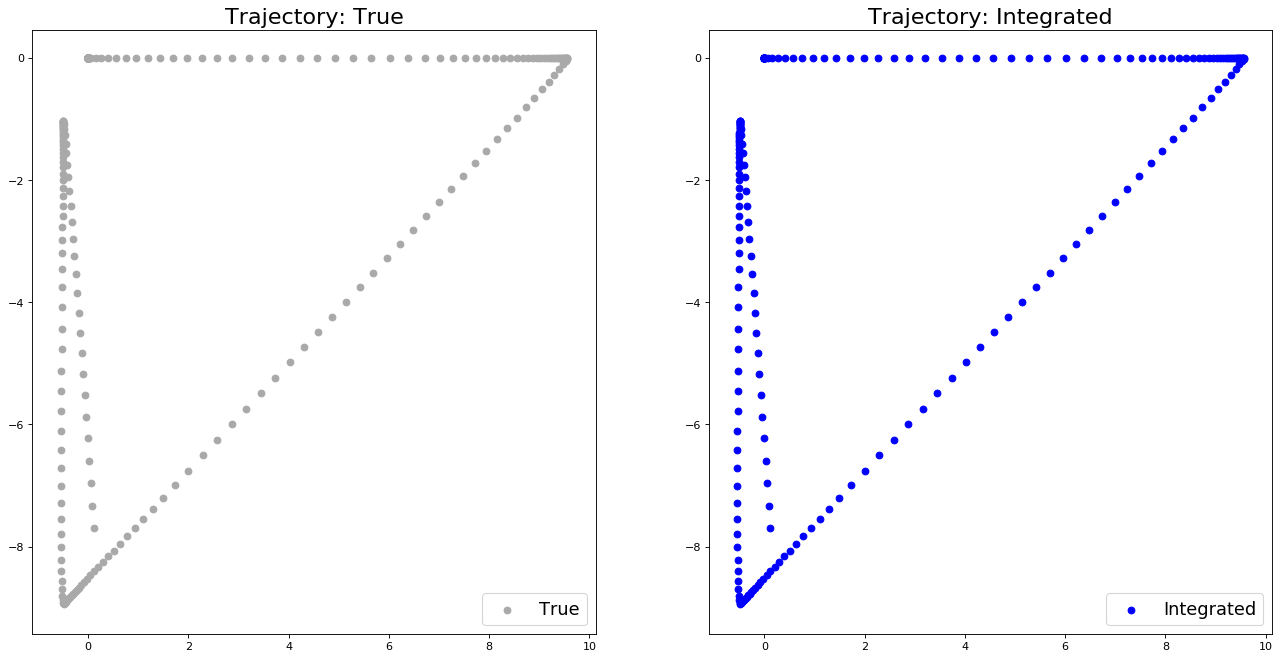

In [102]:
gen2 = integrateTrajectoryVelocityBody(position=dataset.loc[0, ['x', 'y', 'z']].values,
                                       orientation=Quaternion(dataset.loc[0, ['scalar', 'i', 'j', 'k']].values),
                                       linearVelocities=y[['dXB', 'dYB', 'dZB']].values,
                                       angularVelocities=y[['dRoll', 'dPitch', 'dYaw']].values,
                                       frequency=frequency * np.ones((plot_limit, )))

plt.figure(num=None, figsize=(20, 10), dpi=80, facecolor='w', edgecolor='k')

for i in range(1, plot_limit):
    # ------------------
    plt.subplot(1, 2, 1)
    plt.legend(['True'], fontsize=16)
    plt.title('Trajectory: True', fontdict={'fontsize':20})
    
    pTrue = dataset.loc[i, ['x', 'y', 'z']]
    oTrue = dataset.loc[i, ['roll', 'pitch', 'yaw']]
    plt.scatter(pTrue[0], pTrue[1], color='darkgrey')
    
    # -----------------
    plt.subplot(1, 2, 2)
    plt.legend(['Integrated'], fontsize=16)
    plt.title('Trajectory: Integrated', fontdict={'fontsize':20})
    
    o, p, _, _ = next(gen2)
    plt.scatter(p[0], p[1], color='blue') 
    
    try:
        assert(np.allclose(p.astype(np.float64), pTrue.astype(np.float64)))
    except:
        print('Unit test failed! at: {} after {} seconds'.format(i, int(i/frequency)))
        break
    
    if i == plot_limit - 1:
        print('Unit test passed!!')

## Data Exploration 
units are m/s and rad/s

In [13]:
dataset[X.columns[:-4]].describe()

,dXB,dYB,dZB,dRoll,dPitch,dYaw,roll,pitch
count,3.563100e+04,3.563100e+04,35631.000000,3.563100e+04,3.563100e+04,3.563100e+04,3.563100e+04,3.563100e+04
mean,-1.437218e-02,-2.688410e-02,-0.001864,-1.192942e-03,8.375298e-03,8.444422e-02,3.371103e-03,-1.568176e-02
std,1.282397e+00,1.299051e+00,0.250865,4.585740e-02,7.250722e-01,5.128511e-01,3.230076e-02,1.460400e-01
min,-3.877071e+00,-3.876497e+00,-4.311520,-3.237352e-01,-2.636127e+00,-1.047195e+00,-1.076750e-01,-3.600370e-01
25%,-5.448388e-01,-6.268908e-01,-0.043713,-7.641260e-03,-7.685219e-02,-1.866346e-06,-9.812929e-04,-1.111820e-01
50%,-9.956547e-10,-1.087952e-09,0.016056,-2.388220e-07,7.312088e-08,1.075034e-07,2.281902e-07,-1.829759e-09
75%,5.202256e-01,5.312344e-01,0.121287,2.756100e-03,1.222911e-01,1.492053e-01,9.429372e-03,6.466343e-02
max,3.763646e+00,3.860891e+00,0.743202,3.292113e-01,2.627451e+00,1.047195e+00,1.074887e-01,3.576003e-01


In [119]:
action_counts = dataset['aName'].value_counts()

#### Actions sets consist of [Yaw-Clockwise, Yaw-AntiClockwise, Move-Forward, Hover]

<img src='images/roll.gif' width="500" height="600">

### Distribution of actions

In [162]:
l = np.array(list(action_counts.items()))

p = figure(x_range=l[:,0], plot_height=400, plot_width=950)
p.vbar(x=l[:,0], top=l[:, 1], width=0.45)
show(p)

### Data ranges

In [155]:
ranges = dataset[X.columns[:-4]].describe()
max_min = pd.DataFrame({'field':a, 'max':c['max'], 'min':c['min']} for a, c in ranges.to_dict().items())

p = figure(x_range=np.array(max_min.field), plot_height=400, plot_width=950)
p.vbar(x=np.array(max_min.field), top=max_min['max'].values, width=0.9)
p.vbar(x=np.array(max_min.field), top=max_min['min'].values, width=0.9, color='purple')
show(p)

## Velocity based models

In [53]:
from sklearn.metrics import mean_squared_error
from sklearn.multioutput import MultiOutputRegressor

### MLP Regressor with grid-search with cross-validation over model parameters

In [54]:
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor

parameters = {'hidden_layer_sizes':[(36, )], 'alpha': np.geomspace(1e-7, 1e-1, 40)}
clf = GridSearchCV(MLPRegressor(max_iter=int(10e3), random_state=10, early_stopping=True), parameters, n_jobs=-1).fit(xTrain, yTrain)

mlp_cv = clf.best_estimator_

#### best estimator resulting from Gridsearchcv

In [55]:
mlp_cv

MLPRegressor(activation='relu', alpha=0.002030917620904739, batch_size='auto',
       beta_1=0.9, beta_2=0.999, early_stopping=True, epsilon=1e-08,
       hidden_layer_sizes=(36,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=10000, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=10, shuffle=True,
       solver='adam', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

In [56]:
yPredicted = pd.DataFrame(mlp_cv.predict(xTest), columns=y.columns)
    
mlp = MLPRegressor(hidden_layer_sizes=clf.best_params_['hidden_layer_sizes'],
                   alpha=clf.best_params_['alpha'], max_iter=int(10e8), random_state=10).fit(X, y)

### Gradient Boost  Trees

In [66]:
from sklearn.ensemble import GradientBoostingRegressor

gradient = MultiOutputRegressor(GradientBoostingRegressor(max_depth=5, loss='huber'))\
          .fit(xTrain, yTrain)
    
gradient

MultiOutputRegressor(estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='huber', max_depth=5,
             max_features=None, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False),
           n_jobs=1)

In [58]:
def predict(actions, position, orientation, x0, model, frequency=10, limit=100):
    for i in range(0, limit):
        if i > 0:
            roll, pitch, yaw = toEulerianAngle(orientation)
            x0 = np.concatenate((linearVelocity, angularVelocity, [roll, pitch] , actions[i]))
            
        s1 = model.predict(x0.reshape(1, -1)).reshape(6,)
        
        orientation, position, linearVelocity, angularVelocity=\
        next(integrateTrajectoryVelocityBody(position=position, orientation=orientation,
                                             frequency=[frequency],
                                             linearVelocities=[s1[[0, 1, 2]]],
                                             angularVelocities=[s1[[3, 4, 5]]]))
        yield orientation, position, linearVelocity, angularVelocity

## Model Evaluation

#### MLP RMSE on test dataset (units are meter/sec and deg/sec)

In [59]:
error_1 = []
for i, c in enumerate(y.columns):
    error = mean_squared_error(yPredicted[c], yTest[c]) ** 0.5
    error_1.append(error)
    print(c + '\t', np.rad2deg(error) if i > 2 else error)

dXB	 0.035535453276990564
dYB	 0.011087754479871377
dZB	 0.03875872172140789
dRoll	 1.0373325096291517
dPitch	 2.6642217733382485
dYaw	 2.1768318760859002


#### Gradient Boost RMSE on test dataset (units are meter/sec and deg/sec)

In [67]:
yPredicted_2 = pd.DataFrame(gradient.predict(xTest), columns=y.columns)

error_2 = []
for i, c in enumerate(y.columns):
    error = mean_squared_error(yPredicted_2[c], yTest[c]) ** 0.5
    error_2.append(error)
    print(c + '\t', np.rad2deg(error) if i > 2 else error)

dXB	 0.029079627629033954
dYB	 0.004459438027370283
dZB	 0.01728814101802236
dRoll	 0.7751210419850098
dPitch	 3.8008810957492476
dYaw	 1.51341296611495


#### Comparing Gradient Boosted Trees vs MLP

In [68]:
diff = np.array(error_1) - np.array(error_2)

print('MLP is better at predicting: ', y.columns[diff < 0])
print('Gradient-B-Trees is better at predicting: ', y.columns[diff > 0])

MLP is better at predicting:  Index(['dPitch'], dtype='object')
Gradient-B-Trees is better at predicting:  Index(['dXB', 'dYB', 'dZB', 'dRoll', 'dYaw'], dtype='object')


#### Performance benchmarks (prediction time) averaged across 80000 predictions

In [64]:
from timeit import timeit

t1 = timeit(partial(mlp_cv.predict, np.ones((1, 12))), number=80000)
t2 = timeit(partial(gradient.predict, np.ones((1, 12))), number=80000)

print('MLP takes {} seconds per prediction'.format(t1))
print('GBT takes {} seconds per prediction'.format(t2))

print('-' * 10 +'\nMLP is {} faster'.format(t2/t1))

MLP takes 2.306706187999225 seconds per prediction
GBT takes 45.19367891299771 seconds per prediction
----------
MLP is 19.59229968173688 faster


#### Gradient Boosted trees are 20 times slower per prediction than MLP 

## Integrated trajectories of random samples from test dataset (20 seconds each)

### MLP

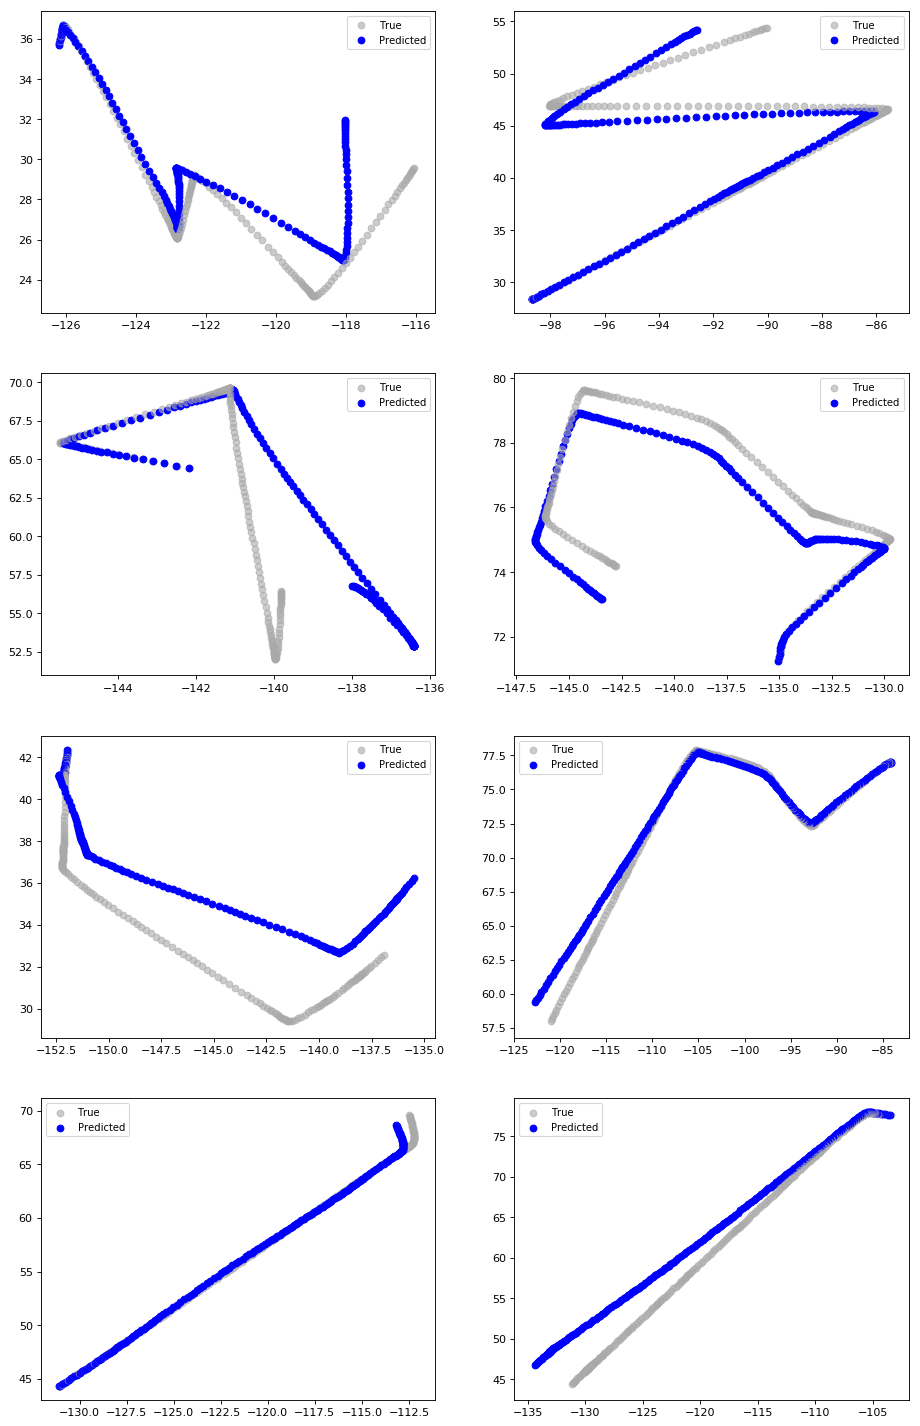

In [73]:
plt.figure(num=None, figsize=(14, 23), dpi=80, facecolor='w', edgecolor='k')

limit = 200

for j in range(1, 9):
    shift = np.random.randint(xTest.shape[0]-limit)

    actions = xTest[['moveForward', 'yawCCW', 'yawCW', 'hover']].values[shift:]
    position = dataset.loc[train + shift, ['x', 'y', 'z']].values
    orientation = Quaternion(dataset.loc[train + shift, ['scalar', 'i', 'j', 'k']].values)

    gen2 = predict(position=position, orientation=orientation, x0=xTest.iloc[shift].values, 
                   actions=actions, limit=limit, model=mlp_cv)
    
    for i in range(1, limit):
        pl = plt.subplot(4, 2, j)
        pTrue = dataset.loc[i+train+shift, ['x', 'y', 'z']]
        o, p, _, _ = next(gen2)

        plt.scatter(*pTrue[:-1], color='darkgrey', alpha=0.6)
        plt.scatter(p[0], p[1], color='blue')
        
        plt.legend(['True', 'Predicted'], fontsize=9)

In [81]:
# taken from: https://stackoverflow.com/questions/4633177/c-how-to-wrap-a-float-to-the-interval-pi-pi
def wrapAroundPi(angle):
    return np.arctan2(np.sin(angle), np.cos(angle))

def getOrientationErrorGlobal(angularPosition1, angularPosition0, frequency):
    return getAverage(m1=angularPosition1, m0=angularPosition0, frequency=frequency, wrap=wrapAngleAroundPi)

In [104]:
pos_error_trials = []
velocity_error_trials = []
angular_velocity_error_trials = []
orientation_error_trials = []

for trial in range(10):
    pos_error = np.ones((limit, 3))
    orientation_error = np.ones((limit, 3))
    
    velocity_error = np.ones((limit, 3))
    angular_velocity_error = np.ones((limit, 3))

    shift = np.random.randint(xTest.shape[0]-limit)

    actions = xTest[['moveForward', 'yawCCW', 'yawCW', 'hover']].values[shift:]
    position = dataset.loc[train + shift, ['x', 'y', 'z']].values
    orientation = Quaternion(dataset.loc[train + shift, ['scalar', 'i', 'j', 'k']].values)

    gen2 = predict(position=position, orientation=orientation, x0=xTest.iloc[shift].values, 
                   actions=actions, limit=limit, model=mlp_cv)

    for i in range(1, limit):
        pTrue = dataset.loc[i+train+shift, ['x', 'y', 'z']]
        oTrue = dataset.loc[i+train+shift, ['scalar', 'i', 'j', 'k']]
        
        vTrue = dataset.loc[i+train+shift, ['dXB', 'dYB', 'dZB']]
        wTrue = dataset.loc[i+train+shift, ['dRoll', 'dPitch', 'dYaw']]
        o, p, v, w = next(gen2)

        pos_error[i -1] = p - pTrue
        orientation_error[i -1] = getOrientationErrorGlobal(toEulerianAngle(o) ,toEulerianAngle(oTrue), 1.0)
        velocity_error[i -1] = vTrue - v
        angular_velocity_error[i-1] = wTrue - w

    pos_error_trials.append(pos_error)
    orientation_error_trials.append(orientation_error)
    velocity_error_trials.append(velocity_error)
    angular_velocity_error_trials.append(angular_velocity_error)

In [105]:
averaged_position_error = list(map(lambda ls:
                                   np.array(ls).reshape(-1, 3).mean(axis=0) ,zip(*pos_error_trials)))

averaged_orientation_error = list(map(lambda ls: 
                                      np.array(ls).reshape(-1, 3).mean(axis=0) ,zip(*orientation_error_trials)))

averaged_velocity_error = list(map(lambda ls: 
                                   np.array(ls).reshape(-1, 3).mean(axis=0) ,zip(*velocity_error_trials)))

averaged_angular_velocity_error = list(map(lambda ls: 
                                           np.array(ls).reshape(-1, 3).mean(axis=0) ,zip(*angular_velocity_error_trials)))

In [106]:
error_pos = pd.DataFrame(averaged_position_error, columns=['x', 'y', 'z'])
error_pos['timestep'] = error_pos.index

error_orientation = pd.DataFrame(averaged_orientation_error, columns=['roll', 'pitch', 'yaw'])
error_orientation['timestep'] = error_orientation.index

error_velocity = pd.DataFrame(averaged_velocity_error, columns=['dXB', 'dYB', 'dZB'])
error_velocity['timestep'] = error_velocity.index

error_angular_velocity = pd.DataFrame(averaged_angular_velocity_error, columns=['dRoll', 'dPitch', 'dYaw'])
error_angular_velocity['timestep'] = error_angular_velocity.index

## MLP Stats

### Error in linear velocity across (20 seconds) averaged across 10 random trajectories

In [85]:
output_notebook()
p = figure(plot_width=950, plot_height=400)

p.line(error_velocity['timestep'][:-10], error_velocity.dXB[:-10], line_width=2, color='blue', legend='dXB')
p.line(error_velocity['timestep'][:-10], error_velocity.dYB[:-10], line_width=2, color='red', legend='dYB')
p.line(error_velocity['timestep'][:-10], error_velocity.dZB[:-10], line_width=2, color='purple', legend='dZB')

show(p)

Loading BokehJS ...

### Error in angular velocity across (20 seconds) averaged across 10 random trajectories

In [86]:
output_notebook()
p = figure(plot_width=950, plot_height=400)

p.line(error_angular_velocity['timestep'][:-10], error_angular_velocity.dRoll[:-10], line_width=2, color='blue', legend='dRoll')
p.line(error_angular_velocity['timestep'][:-10], error_angular_velocity.dPitch[:-10], line_width=2, color='red', legend='dPitch')
p.line(error_angular_velocity['timestep'][:-10], error_angular_velocity.dYaw[:-10], line_width=2, color='purple', legend='dYaw')

show(p)

Loading BokehJS ...

### Error in position across (20 seconds) averaged across 10 random trajectories

In [87]:
output_notebook()
p = figure(plot_width=950, plot_height=400)

p.line(error_pos['timestep'][:-10], error_pos.x[:-10], line_width=2, color='blue', legend='x')
p.line(error_pos['timestep'][:-10], error_pos.y[:-10], line_width=2, color='red', legend='y')
p.line(error_pos['timestep'][:-10], error_pos.z[:-10], line_width=2, color='purple', legend='z')

show(p)

Loading BokehJS ...

### Error in Orientation (smallest angle) in radians (20 seconds) averaged across 10 random trajectories

In [88]:
output_notebook()
p = figure(plot_width=950, plot_height=400)

p.line(error_orientation['timestep'][:-10], error_orientation.roll[:-10], line_width=2, color='blue', legend='roll')
p.line(error_orientation['timestep'][:-10], error_orientation.pitch[:-10], line_width=2, color='red', legend='pitch')
p.line(error_orientation['timestep'][:-10], error_orientation.yaw[:-10], line_width=2, color='purple', legend='yaw')

show(p)

Loading BokehJS ...

## Gradient Boosted Trees Stats

### Error in linear velocity across (20 seconds) averaged across 10 random trajectories

In [92]:
output_notebook()
p = figure(plot_width=950, plot_height=400)

p.line(error_velocity['timestep'][:-10], error_velocity.dXB[:-10], line_width=2, color='blue', legend='dXB')
p.line(error_velocity['timestep'][:-10], error_velocity.dYB[:-10], line_width=2, color='red', legend='dYB')
p.line(error_velocity['timestep'][:-10], error_velocity.dZB[:-10], line_width=2, color='purple', legend='dZB')

show(p)

Loading BokehJS ...

### Error in angular velocity (smallest angle) in radians (20 seconds) averaged across 10 random trajectories

In [94]:
output_notebook()
p = figure(plot_width=950, plot_height=400)

p.line(error_angular_velocity['timestep'][:-10], error_angular_velocity.dRoll[:-10], line_width=2, color='blue', legend='dRoll')
p.line(error_angular_velocity['timestep'][:-10], error_angular_velocity.dPitch[:-10], line_width=2, color='red', legend='dPitch')
p.line(error_angular_velocity['timestep'][:-10], error_angular_velocity.dYaw[:-10], line_width=2, color='purple', legend='dYaw')

show(p)

Loading BokehJS ...

### Error in Position (smallest angle) in radians (20 seconds) averaged across 10 random trajectories

In [95]:
output_notebook()
p = figure(plot_width=950, plot_height=400)

p.line(error_pos['timestep'][:-10], error_pos.x[:-10], line_width=2, color='blue', legend='x')
p.line(error_pos['timestep'][:-10], error_pos.y[:-10], line_width=2, color='red', legend='y')
p.line(error_pos['timestep'][:-10], error_pos.z[:-10], line_width=2, color='purple', legend='z')

show(p)

Loading BokehJS ...

### Error in Orientation (smallest angle) in radians (20 seconds) averaged across 10 random trajectories

In [96]:
output_notebook()
p = figure(plot_width=950, plot_height=400)

p.line(error_orientation['timestep'][:-10], error_orientation.roll[:-10], line_width=2, color='blue', legend='roll')
p.line(error_orientation['timestep'][:-10], error_orientation.pitch[:-10], line_width=2, color='red', legend='pitch')
p.line(error_orientation['timestep'][:-10], error_orientation.yaw[:-10], line_width=2, color='purple', legend='yaw')

show(p)

Loading BokehJS ...

### GBT error variance (multistep)

In [100]:
np.std(error_pos) ** 2

x              0.888438
y              0.066446
z              0.039534
timestep    3333.250000
dtype: float64

In [101]:
np.std(error_orientation) ** 2

roll           0.005443
pitch          0.005115
yaw            0.008805
timestep    3333.250000
dtype: float64

### MLP error variance (multistep)

In [107]:
np.std(error_pos) ** 2

x              0.035295
y              0.011301
z              0.226235
timestep    3333.250000
dtype: float64

In [108]:
np.std(error_orientation) ** 2

roll           0.004998
pitch          0.004999
yaw            0.017678
timestep    3333.250000
dtype: float64

### MLP has lower variance than GBT in multistep predictions despite having higher RMSE on test dataset

## Model Verification

obtained model is used in a simulated environment, and controlled manually (actions taken at each time step is displayed)

<img src='images/demo3.gif'>

### Model successfully captures multirotor dynamics!!

## Conclusion

#### 1. MLP has higher RMSE on test dataset, but has lower variance on multistep ahead predictions.
#### 2. MLP is 20x times faster than GBT per prediction.
#### 3. MLP successfully captures multirotor dynamics including non-linear effects like inertia.
#### 4. A better model was obtained by decoupling multirotor actions (allowing only one action to be selected at any timestep)
#### 5. MLP can do reliable multistep ahead predictions 

In [ ]:
joblib.dump(gradient, '../models/gradient-m.model')

In [136]:
joblib.dump(mlp, '../models/nn-m.model')

['../models/nn-m.model']